(optional)

In [1]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')

In [2]:
# os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [3]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [4]:
data = np.load('data.npz')
label = np.load('label.npz')

In [5]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [6]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [7]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

## Model Implementation Part

### LSTM

In [8]:
# Preprocessing
lstm_X_train = X_train.swapaxes(1, 2)
lstm_X_val = X_val.swapaxes(1, 2)
lstm_X_test = X_test.swapaxes(1, 2)
lstm_X_train.shape, lstm_X_val.shape, lstm_X_test.shape

((604, 200, 22), (152, 200, 22), (190, 200, 22))

In [9]:
# Build your model here:
lstm_model = models.Sequential()
lstm_model.add(tf.keras.Input((200, 22)))
lstm_model.add(layers.LSTM(128, input_shape=(200, 22)))
lstm_model.add(layers.Flatten())
lstm_model.add(layers.Dense(64, activation="softmax"))
lstm_model.add(layers.Dense(6, activation="softmax"))
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), ]
)
lstm_model.build()
lstm_model.summary()

callback = callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
lstm_history = lstm_model.fit(lstm_X_train, Y_train, validation_data=(lstm_X_val, Y_val), batch_size=8, epochs=100, callbacks=callback)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               77312     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 85,958
Trainable params: 85,958
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
76/76 [==============================] - 12s 127ms/step - loss: 1.7869 - sparse_categorical_accuracy: 0.2964 - val_loss: 1.7808 - val_sparse_categorical_accuracy: 0.3750
Ep

In [10]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True)

5/5 [==============================] - 0s 49ms/step - loss: 0.9079 - sparse_categorical_accuracy: 0.9079


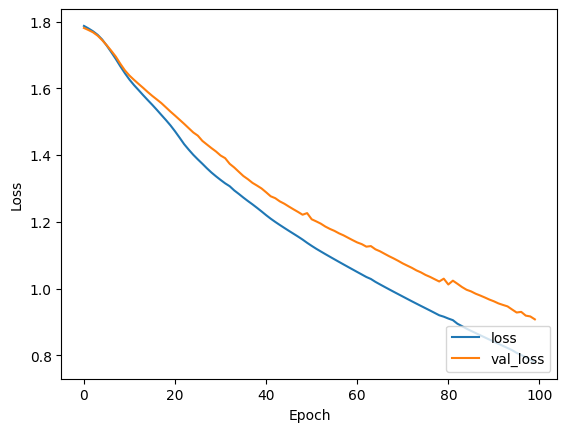

In [11]:
# plot loss curve
plt.plot(lstm_history.history['loss'], label='loss')
plt.plot(lstm_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

train_loss = lstm_model.evaluate(lstm_X_train, Y_train)
val_loss = lstm_model.evaluate(lstm_X_val, Y_val)

5/5 [==============================] - 0s 51ms/step - loss: 0.9079 - sparse_categorical_accuracy: 0.9079


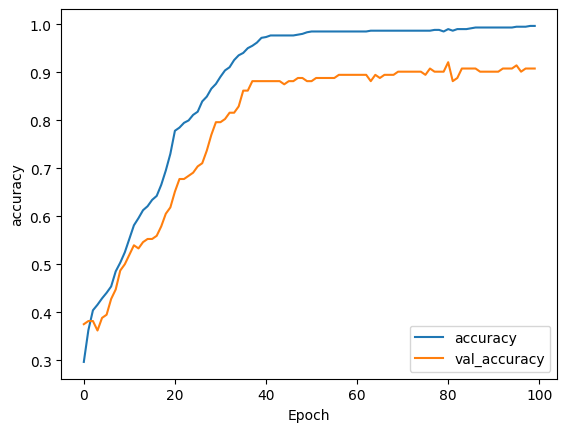

In [12]:
# plot loss curve
plt.plot(lstm_history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(lstm_history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

train_acc = lstm_model.evaluate(lstm_X_train, Y_train)
val_acc = lstm_model.evaluate(lstm_X_val, Y_val)

In [13]:
pred = lstm_model.predict(lstm_X_test)
pred = tf.argmax(pred, axis=1)
output = tf.expand_dims(pred, 1)
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, fmt="%i", delimiter=",")

6/6 [==============================] - 1s 41ms/step


### EEGNet

In [14]:
# Build your model here:
D = 2 # Number of spatial filters to learn within each temporal convolution
F1 = 8
F2 = F1 * D
C = 22 # channels
T = 200 # time samples
normRate = 0.25
dropoutRate = 0.5
kernelLength = 64 # length of temporal convolution in first layer
nb_classes = 6 # number of classes to classify
eeg_model = models.Sequential()
eeg_model.add(tf.keras.Input(shape=(C, T, 1)))
eeg_model.add(layers.Conv2D(F1, (1, kernelLength), padding="same", input_shape=(C, T, 1), use_bias=False))
eeg_model.add(layers.BatchNormalization())
eeg_model.add(layers.DepthwiseConv2D((C, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.)))
eeg_model.add(layers.BatchNormalization())
eeg_model.add(layers.Activation(activation="elu"))
eeg_model.add(layers.AveragePooling2D((1, 4)))
eeg_model.add(layers.Dropout(dropoutRate))

eeg_model.add(layers.SeparableConv2D(F2, (1, 16), use_bias=False, padding="same"))
eeg_model.add(layers.BatchNormalization())
eeg_model.add(layers.Activation(activation="elu"))
eeg_model.add(layers.AveragePooling2D((1, 8)))
eeg_model.add(layers.Dropout(dropoutRate))

eeg_model.add(layers.Flatten(name="flatten"))

eeg_model.add(layers.Dense(nb_classes, name="dense", kernel_constraint=tf.keras.constraints.max_norm(normRate)))
eeg_model.add(layers.Activation(activation="softmax", name="softmax"))
eeg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), ]
)
eeg_model.build()
eeg_model.summary()

callback = callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
eeg_history = eeg_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=8, epochs=100, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 200, 8)        512       
                                                                 
 batch_normalization (BatchN  (None, 22, 200, 8)       32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 200, 16)       352       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 200, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1, 200, 16)        0         
                                                      

5/5 [==============================] - 0s 16ms/step - loss: 0.4727 - sparse_categorical_accuracy: 0.9671


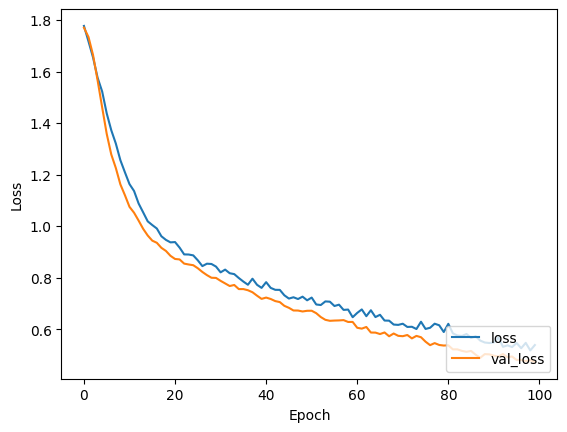

In [15]:
# plot loss curve
plt.plot(eeg_history.history['loss'], label='loss')
plt.plot(eeg_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

train_loss = eeg_model.evaluate(X_train, Y_train)
val_loss = eeg_model.evaluate(X_val, Y_val)

5/5 [==============================] - 0s 16ms/step - loss: 0.4727 - sparse_categorical_accuracy: 0.9671


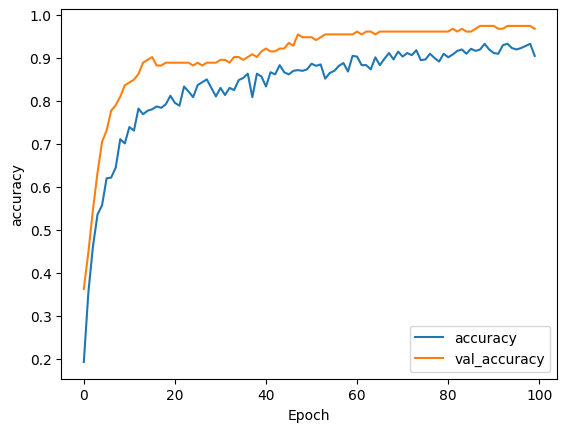

In [16]:
# plot loss curve
plt.plot(eeg_history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(eeg_history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

train_acc = eeg_model.evaluate(X_train, Y_train)
val_acc = eeg_model.evaluate(X_val, Y_val)

In [17]:
pred = eeg_model.predict(X_test)
pred = tf.argmax(pred, axis=1)
output = tf.expand_dims(pred, 1)
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, fmt="%i", delimiter=",")

6/6 [==============================] - 0s 13ms/step


## Model Competition Part

In [18]:
# Build your model here:
D = 2 # Number of spatial filters to learn within each temporal convolution
F1 = 8
F2 = F1 * D
C = 22 # channels
T = 200 # time samples
normRate = 0.25
dropoutRate = 0.5
kernelLength = 64 # length of temporal convolution in first layer
nb_classes = 6 # number of classes to classify
model = models.Sequential()
model.add(tf.keras.Input(shape=(T, C)))
model.add(layers.LSTM(128, input_shape=(T, C), return_sequences=True))
model.add(layers.Reshape((T, 128, 1)))
model.add(layers.Conv2D(F1, (1, kernelLength), padding="same", use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((T, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=tf.keras.constraints.max_norm(1.)))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation="elu"))
model.add(layers.AveragePooling2D((1, 4)))
model.add(layers.Dropout(dropoutRate))

model.add(layers.SeparableConv2D(F2, (1, 16), use_bias=False, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation="elu"))
model.add(layers.AveragePooling2D((1, 8)))
model.add(layers.Dropout(dropoutRate))

model.add(layers.Flatten(name="flatten"))

model.add(layers.Dense(nb_classes, name="dense", kernel_constraint=tf.keras.constraints.max_norm(normRate)))
model.add(layers.Activation(activation="softmax", name="softmax"))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), ]
)
model.build()
model.summary()

callback = callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(lstm_X_train, Y_train, validation_data=(lstm_X_val, Y_val), batch_size=8, epochs=100, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200, 128)          77312     
                                                                 
 reshape (Reshape)           (None, 200, 128, 1)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 128, 8)       512       
                                                                 
 batch_normalization_3 (Batc  (None, 200, 128, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 128, 16)       3200      
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 128, 16)      

5/5 [==============================] - 1s 171ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.9868


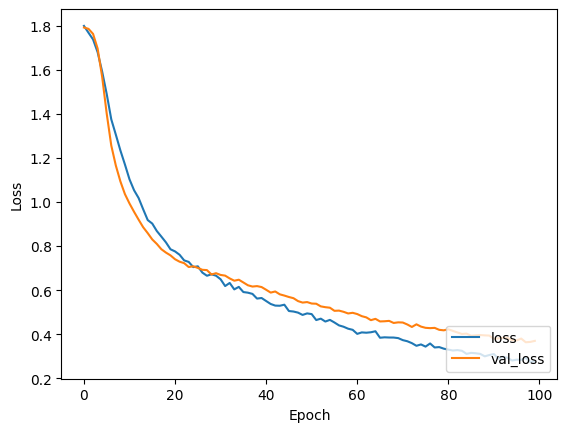

In [19]:
# plot loss curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

train_loss = model.evaluate(lstm_X_train, Y_train)
val_loss = model.evaluate(lstm_X_val, Y_val)

5/5 [==============================] - 1s 162ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.9868


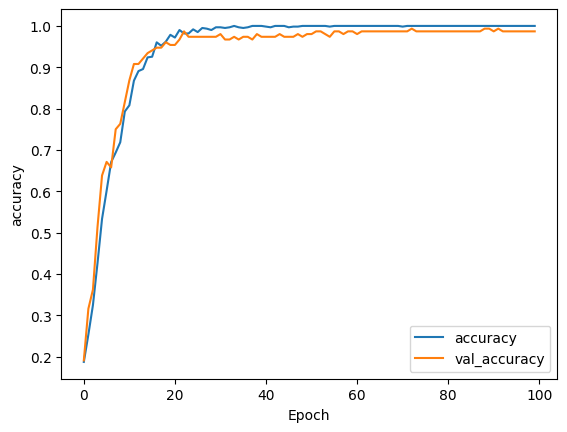

In [20]:
# plot loss curve
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

train_acc = model.evaluate(lstm_X_train, Y_train)
val_acc = model.evaluate(lstm_X_val, Y_val)

In [21]:
pred = model.predict(lstm_X_test)
pred = tf.argmax(pred, axis=1)
output = tf.expand_dims(pred, 1)
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, fmt="%i", delimiter=",")

6/6 [==============================] - 1s 162ms/step
